# Website Purchase Propensity Model

This project builds a session-level purchase propensity model using website event data. User behavior is aggregated at the session level and used to predict the likelihood of purchase using logistic regression and a Random Forest classifier, with a focus on balancing predictive performance and business applicability.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

In [4]:
file_path = r"C:\Users\malar\OneDrive\Desktop\Data Science Projects\2019-Oct.csv"

In [5]:
df = pd.read_csv(file_path, nrows=50000)

In [6]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [7]:
df['event_type'].value_counts()

event_type
view        48676
purchase      748
cart          576
Name: count, dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   event_time     50000 non-null  object 
 1   event_type     50000 non-null  object 
 2   product_id     50000 non-null  int64  
 3   category_id    50000 non-null  int64  
 4   category_code  33902 non-null  object 
 5   brand          42959 non-null  object 
 6   price          50000 non-null  float64
 7   user_id        50000 non-null  int64  
 8   user_session   50000 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 3.4+ MB


In [9]:
# create a session-level purchase indicator
session_purchase = (
    df.groupby('user_session')['event_type']
    .apply(lambda x: (x == 'purchase').any())
    .astype(int)
)

session_purchase.head()

user_session
00056e5c-f5b0-464b-84d0-d5d02197c4da    0
0006852b-f9a2-4d84-b439-acc1f9e6771e    0
001259d1-d126-4601-a53e-b511cf3a3152    0
001f8c1d-dc62-4f75-9339-fda1772626f4    0
00322ee2-5eec-4647-9499-eae70633ec5b    0
Name: event_type, dtype: int32

In [10]:
session_purchase.value_counts()

event_type
0    12146
1      652
Name: count, dtype: int64

In [11]:
# filter to product view events only

views_df = df[df['event_type'] == 'view']

In [12]:
#number of views per session
session_page_views = (
    views_df
    .groupby('user_session')
    .size()
)

In [13]:
session_page_views.head()

user_session
00056e5c-f5b0-464b-84d0-d5d02197c4da    2
0006852b-f9a2-4d84-b439-acc1f9e6771e    1
001259d1-d126-4601-a53e-b511cf3a3152    1
001f8c1d-dc62-4f75-9339-fda1772626f4    2
00322ee2-5eec-4647-9499-eae70633ec5b    1
dtype: int64

In [14]:
# filter to add to cart events only
cart_df = df[df['event_type'] == 'cart']

In [15]:
#count number of cart additions per session
session_cart_adds = (
    cart_df
    .groupby('user_session')
    .size()
)

In [16]:
session_cart_adds.head()

user_session
021c155d-0484-4aea-9589-56ff4cb8a6e4    2
02f24adf-a95a-4400-a89c-bccbfec73657    2
036d4ad9-f4e2-4a22-8aa4-9dacfc63921c    1
040a3af4-91c2-4f83-a1d9-35227fdf4241    1
040d0e0b-0a40-4d40-bdc9-c9252e877d9c    1
dtype: int64

In [17]:
#start building the modeling table using page views
model_df = session_page_views.to_frame(name='page_views')

In [18]:
#add cart counts (sessions with no cart adds will be NaN)
model_df = model_df.join(session_cart_adds.to_frame(name='cart_adds'))

In [19]:
# add purchase indicator
model_df = model_df.join(session_purchase.to_frame(name='purchased'))

In [20]:
#replace missing cart_adds with 0
model_df = model_df.fillna(0)

In [21]:
model_df.head()

,page_views,cart_adds,purchased
user_session,,,
00056e5c-f5b0-464b-84d0-d5d02197c4da,2,0.0,0
0006852b-f9a2-4d84-b439-acc1f9e6771e,1,0.0,0
001259d1-d126-4601-a53e-b511cf3a3152,1,0.0,0
001f8c1d-dc62-4f75-9339-fda1772626f4,2,0.0,0
00322ee2-5eec-4647-9499-eae70633ec5b,1,0.0,0


In [22]:
model_df.describe()

,page_views,cart_adds,purchased
count,12796.000000,12796.000000,12796.000000
mean,3.804001,0.045014,0.050797
std,4.994475,0.341487,0.219592
min,1.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000
75%,4.000000,0.000000,0.000000
max,91.000000,15.000000,1.000000


In [23]:
model_df['purchased'].value_counts()

purchased
0    12146
1      650
Name: count, dtype: int64

In [24]:
#features

x = model_df[['page_views', 'cart_adds']]

#target

y = model_df['purchased']

In [25]:
x.head(), y.head()

(                                      page_views  cart_adds
 user_session                                               
 00056e5c-f5b0-464b-84d0-d5d02197c4da           2        0.0
 0006852b-f9a2-4d84-b439-acc1f9e6771e           1        0.0
 001259d1-d126-4601-a53e-b511cf3a3152           1        0.0
 001f8c1d-dc62-4f75-9339-fda1772626f4           2        0.0
 00322ee2-5eec-4647-9499-eae70633ec5b           1        0.0,
 user_session
 00056e5c-f5b0-464b-84d0-d5d02197c4da    0
 0006852b-f9a2-4d84-b439-acc1f9e6771e    0
 001259d1-d126-4601-a53e-b511cf3a3152    0
 001f8c1d-dc62-4f75-9339-fda1772626f4    0
 00322ee2-5eec-4647-9499-eae70633ec5b    0
 Name: purchased, dtype: int32)

In [26]:
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [27]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((10236, 2), (2560, 2), (10236,), (2560,))

In [28]:
print("Train purchase rate:")
print(y_train.value_counts(normalize=True))

print("\nTest purchase rate:")
print(y_test.value_counts(normalize=True))

Train purchase rate:
purchased
0    0.949199
1    0.050801
Name: proportion, dtype: float64

Test purchase rate:
purchased
0    0.949219
1    0.050781
Name: proportion, dtype: float64


In [29]:
#train logistic regression model with feature scaling

logreg_model = Pipeline(steps=[
    ("scaler", StandardScaler()),
     ("logreg", LogisticRegression(max_iter=1000, random_state=42))
])

logreg_model.fit(x_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg', LogisticRegression(max_iter=1000, random_state=42))])

In [30]:
y_pred = logreg_model.predict(x_test)

In [31]:
y_proba = logreg_model.predict_proba(x_test)[:, 1]

In [32]:
#evaluate model performance

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.95234375
ROC-AUC: 0.7310826210826211

Confusion Matrix:
 [[2423    7]
 [ 115   15]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98      2430
           1       0.68      0.12      0.20       130

    accuracy                           0.95      2560
   macro avg       0.82      0.56      0.59      2560
weighted avg       0.94      0.95      0.94      2560



## Logistic Regression Results

This model predicts the likelihood that a browsing session will result in a purchase. Because purchases are relatively rare (~5%), ROC-AUC is used as the primary evaluation metric.

The logistic regression achieved a ROC-AUC of ~0.73, indicating the model can distinguish between purchasing and non-purchasing sessions better than random chance.

The model shows high precision but low recall for purchasers, meaning it is conservative and only predicts a purchase when confidence is high.

In [34]:
y_proba[:10]

array([0.9669131 , 0.03702574, 0.03604515, 0.04346918, 0.03803195,
       0.03803195, 0.0401237 , 0.0390644 , 0.03604515, 0.05097459])

In [35]:
#set a custom decision threshold
threshold = 0.30

y_pred_30 = (y_proba >= threshold).astype(int)

In [36]:
print("Confusion Matrix (threshold = 0.30):")
print(confusion_matrix(y_test, y_pred_30))

print("\nClassification Report (threshold = 0.30):")
print(classification_report(y_test, y_pred_30))

Confusion Matrix (threshold = 0.30):
[[2417   13]
 [ 112   18]]

Classification Report (threshold = 0.30):
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      2430
           1       0.58      0.14      0.22       130

    accuracy                           0.95      2560
   macro avg       0.77      0.57      0.60      2560
weighted avg       0.94      0.95      0.94      2560



## Decision Threshold Analysis

The default 0.50 probability threshold resulted in conservative predictions with high precision but low recall. Lowering the threshold to 0.30 increased recall by identifying additional purchasing sessions, at the cost of more false positives.

While threshold tuning improved buyer capture modestly, the results indicate that model performance is primarily limited by feature simplicity, motivating the evaluation of more expressive models.

In [38]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)

rf_model.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [39]:
#class predictions
y_pred_rf = rf_model.predict(x_test)

#probability predictions
y_proba_rf = rf_model.predict_proba(x_test)[:, 1]

In [40]:
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

Accuracy: 0.780078125
ROC-AUC: 0.7282684393795504

Confusion Matrix:
[[1922  508]
 [  55   75]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.79      0.87      2430
           1       0.13      0.58      0.21       130

    accuracy                           0.78      2560
   macro avg       0.55      0.68      0.54      2560
weighted avg       0.93      0.78      0.84      2560



## Random Forest Model

A Random Forest Classifier was trained to evaluate whether non-linear relationships between session behavior features could improve
purchase prediction performance. Unlike logistic regression, Random Forest can automatically capture interactions and threshold effects.

To account for the class imbalance in purchase behavior, class weights were balanced to emphasize correctly identifying purchasing sessions.

## Model Comparison: Logistic Regression vs Random Forest

Logistic regression provided a strong baseline with high precision but low recall for purchasing sessions, identifying only the most confident buyers.

The Random Forest model significantly increased recall, capturing approximately 58% of purchasing sessions, at the cost of increased false positives and reduced overall accuracy.

This tradeoff highlights the importance of aligning model choice with business goals. For low-cost marketing actions, the Random Forest approach may be preferable due to its ability to identify a broader set of high intent sessions.

In [43]:
feature_importance = pd.DataFrame({
    "feature": x_train.columns,
    "importance": rf_model.feature_importances_
}).sort_values(by="importance", ascending=False)

feature_importance

,feature,importance
1,cart_adds,0.643356
0,page_views,0.356644


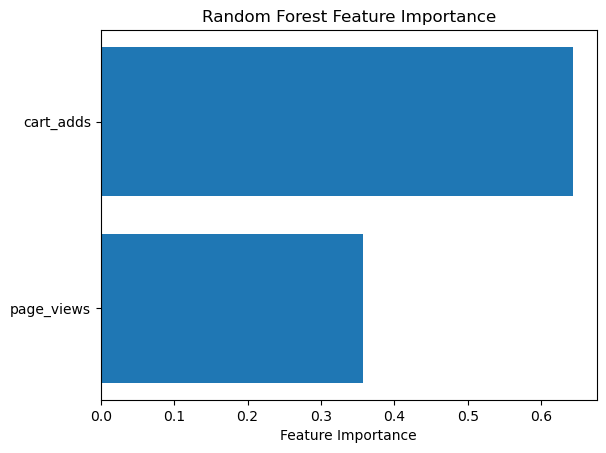

In [44]:
plt.barh(
    feature_importance["feature"],
    feature_importance["importance"]
)

plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()
plt.show()

## Random Forest Feature Importance

Feature importance analysis shows that cart-related activity is the strongest driver of purchase prediction, contributing more to model decisions
than overall page views. This aligns with expected user behavior, where active engagement (adding items to cart) signals higher purchase intent than passive browsing alone.

## Final Model Recommendation

Two models were evaluated to predict purchase likelihood at the session level: logistic regression and a Random Forest Classifier.
Logistic regression provided a strong and interpretable baseline, achieving high precision but low recall for purchasing sessions. This
model is well-suited for scenarios where actions taken on predictions are costly, and precision is prioritized. The Random Forest model
demonstrated a substantially higher recall, identifying a much larger proportion of purchasing sessions at the expense of additional false
positives. This behavior reflects the model's ability to capture non-linear relationships and interactions between browsing and cart activity.
Random Forest model is recommended when the primary objective is maximizing buyer identification. Logistic regression remains valuable as a benchmark
and for scenarios requiring greater interpretability.

## Business Insights 

This analysis highlights the importance of active engagement signals in predicting purchase behavior. Cart-related actions were the strongest driver of
purchase intent, outweighing passive indicators such as page views. This suggests that user behaviors reflecting commitment, rather than interest
alone, are most predictive of conversion. From a business perspective, this model could be used to prioritize high-intent sessions for targeted marketing
actions such as personalized product recommendations, retargeting campaigns, or promotional messaging. Adjusting decision thresholds allows the model
to be tailored to different campaign objectives, balancing conversion lift against outreach costs. If extended further, additional features such as time
spent per session, product price ranges, or recency of user activity could improve predictive performance. 